* Tutorial on using `TFRecord` and `tf.Example`. 
*  See `TFRecord and tf.Example | TensorFlow Core.html` in current directory for more.

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.python.client import device_lib
import numpy as np
import sys
import IPython.display as display

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10981503717130082683, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18429967603983202656
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1189419769744948537
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6771435111
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11276686631857154856
 physical_device_desc: "device: 0, name: GeForce RTX 2080 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
print(tf.__version__)
print(sys.version)

1.15.3
2.7.17 (default, Apr 15 2020, 17:20:14) 
[GCC 7.5.0]


In [4]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [5]:
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))


bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.71828174591
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [6]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

'\x12\x06\n\x04T\xf8-@'

In [7]:
# number of observations
n_obs = int(1e4)

#Bool features, encoded as True or False
feature0 = np.random.choice([True, False], n_obs)

#Integer features chosen randomly from [0,4]
feature1 = np.random.choice(range(5), n_obs)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature
feature3 = np.random.randn(n_obs)

In [8]:
strings.dtype

dtype('S7')

In [12]:
print(strings[0].dtype)
print(strings[0].nbytes)
print(strings[0])

|S3
3
cat


In [10]:
print(feature2[0].dtype)
print(feature2[0].nbytes)

|S4
4


In [11]:
feature2[0]

'goat'

In [13]:
def serialize_example(feature0, feature1, feature2, feature3):
    """
    create tf.Example message file ready to be written to a file
    """
    
    # create a dictionary mapping feature name to tf.Example compatible data types
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3)
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()
    

In [14]:
example_ob = [feature0[0], feature1[1], feature2[2], feature3[3]]
print(example_ob)
serialized_example = serialize_example(*example_ob)
serialized_example

[True, 0, 'goat', -0.8768661700979804]


'\nR\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04Mz`\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00'

In [19]:
type(serialized_example)

str

In [15]:
example_proto = tf.train.Example.FromString(serialized_example)
print(example_proto)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.876866161823
      }
    }
  }
}



In [16]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))

In [26]:
features_dataset

<DatasetV1Adapter shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [18]:
for f0, f1, f2, f3 in features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(goat, shape=(), dtype=string)
tf.Tensor(-0.5468848099452791, shape=(), dtype=float64)


In [21]:
def tf_serialize_example(f0, f1, f2, f3):
    tf_string = tf.py_function(serialize_example,
                               (f0, f1, f2, f3),
                               tf.string)
    #return tf.reshape(tf_string, ()) # The result is a scalar
    return tf_string

tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: id=25, shape=(), dtype=string, numpy='\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa5\x00\x0c\xbf'>

In [22]:
def tf_serialize_example(f0, f1, f2, f3):
    tf_string = tf.py_function(serialize_example,
                               (f0, f1, f2, f3),
                               tf.string)
    return tf.reshape(tf_string, ()) # The result is a scalar
    #return tf_string

tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: id=34, shape=(), dtype=string, numpy='\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa5\x00\x0c\xbf'>

In [23]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<DatasetV1Adapter shapes: (), types: tf.string>

In [27]:
def generator():
    for features in features_dataset:
        yield serialize_example(*features)

In [28]:
serialized_features_dataset = tf.data.Dataset.from_generator(generator, output_types=tf.string, output_shapes=())
serialized_features_dataset

<DatasetV1Adapter shapes: (), types: tf.string>

In [29]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)


In [30]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV1 shapes: (), types: tf.string>

In [34]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: id=50147, shape=(), dtype=string, numpy='\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa5\x00\x0c\xbf'>
<tf.Tensor: id=50148, shape=(), dtype=string, numpy='\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x9c\x15\x15\xc0'>
<tf.Tensor: id=50149, shape=(), dtype=string, numpy='\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x16\x91\t\xc0'>
<tf.Tensor: id=50150, shape=(), dtype=string, numpy='\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04Mz`\xbf'>
<

In [37]:
feature_description = {
    'feature0':tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1':tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2':tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3':tf.io.FixedLenFeature([], tf.float32, default_value=0.0)
}

def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

In [38]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<DatasetV1Adapter shapes: {feature2: (), feature3: (), feature0: (), feature1: ()}, types: {feature2: tf.string, feature3: tf.float32, feature0: tf.int64, feature1: tf.int64}>

In [39]:
for parsed_record in parsed_dataset.take(10):
    print(repr(parsed_record))

{'feature2': <tf.Tensor: id=50201, shape=(), dtype=string, numpy='goat'>, 'feature3': <tf.Tensor: id=50202, shape=(), dtype=float32, numpy=-0.54688483>, 'feature0': <tf.Tensor: id=50199, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=50200, shape=(), dtype=int64, numpy=4>}
{'feature2': <tf.Tensor: id=50205, shape=(), dtype=string, numpy='cat'>, 'feature3': <tf.Tensor: id=50206, shape=(), dtype=float32, numpy=-2.329444>, 'feature0': <tf.Tensor: id=50203, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=50204, shape=(), dtype=int64, numpy=0>}
{'feature2': <tf.Tensor: id=50209, shape=(), dtype=string, numpy='goat'>, 'feature3': <tf.Tensor: id=50210, shape=(), dtype=float32, numpy=-2.1494803>, 'feature0': <tf.Tensor: id=50207, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=50208, shape=(), dtype=int64, numpy=4>}
{'feature2': <tf.Tensor: id=50213, shape=(), dtype=string, numpy='dog'>, 'feature3': <tf.Tensor: id=50214, shape=(), dtype=float32, numpy=-0.87

In [40]:
with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_obs):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)

In [41]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV1 shapes: (), types: tf.string>

In [42]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.546884834766
      }
    }
  }
}



In [43]:
t

'\nR\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04Mz`\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00'

In [44]:
tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: id=60267, shape=(), dtype=string, numpy='\nR\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa5\x00\x0c\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04'>

In [46]:
tf_serialize_example(f0,f1,f2,f3).numpy()

'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa5\x00\x0c\xbf'

In [51]:
tf.train.Example.FromString(tf_serialize_example(f0,f1,f2,f3))

TypeError: expected a readable buffer object

In [54]:
a = tf.train.Example.FromString(tf_serialize_example(f0,f1,f2,f3).numpy())
a

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.546884834766
      }
    }
  }
}

In [56]:
a.features.feature['feature0']

int64_list {
  value: 1
}

In [50]:
tf.train.Example.FromString(serialize_example(f0,f1,f2,f3))


features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.546884834766
      }
    }
  }
}

In [57]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

24576/15477 [===============================================] - 0s 0us/step


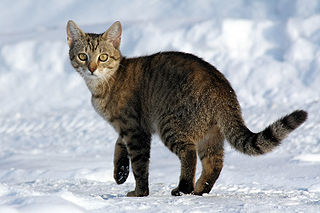

In [58]:
display.display(display.Image(filename=cat_in_snow))


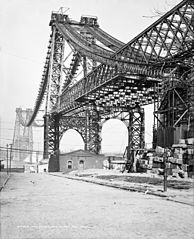

In [59]:
display.display(display.Image(filename=williamsburg_bridge))


In [60]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}


In [64]:
image_string = open(cat_in_snow, 'rb').read()
#image_string
label = image_labels[cat_in_snow]


In [67]:
image_shape = tf.image.decode_jpeg(image_string).shape

In [68]:
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))


In [69]:
temp =image_example(image_string, label)

In [70]:
temp

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\333\000C\000\006\004\005\006\005\004\006\006\005\006\007\007\006\010\n\020\n\n\t\t\n\024\016\017\014\020\027\024\030\030\027\024\026\026\032\035%\037\032\033#\034\026\026 , #&\')*)\031\037-0-(0%()(\377\333\000C\001\007\007\007\n\010\n\023\n\n\023(\032\026\032((((((((((((((((((((((((((((((((((((((((((((((((((\377\300\000\021\010\000\325\001@\003\001\021\000\002\021\001\003\021\001\377\304\000\034\000\000\002\002\003\001\001\000\000\000\000\000\000\000\000\000\000\003\004\002\005\001\006\007\010\000\377\304\000?\020\000\002\001\003\003\002\005\001\005\006\005\002\006\003\000\000\001\002\003\000\004\021\005\022!1A\006\023\"Qaq\007\0242\201\221\

In [107]:
temp.features.feature.keys.image_raw

[u'label', u'depth', u'image_raw', u'width', u'height']

In [71]:
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for filename, label in image_labels.items():
        image_string = open(filename, 'rb').read()
        tf_example = image_example(image_string, label)
        writer.write(tf_example.SerializeToString())

In [73]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

In [98]:
for item in raw_image_dataset.take(1):
    print(repr(item))

<tf.Tensor: id=60547, shape=(), dtype=string, numpy='\n\xa0\x8c\x01\n\xd9\x8b\x01\n\timage_raw\x12\xca\x8b\x01\n\xc6\x8b\x01\n\xc2\x8b\x01\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [76]:
image_feature_descriptor = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_file):
    return tf.io.parse_single_example(example_file, image_feature_descriptor)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<DatasetV1Adapter shapes: {image_raw: (), depth: (), label: (), width: (), height: ()}, types: {image_raw: tf.string, depth: tf.int64, label: tf.int64, width: tf.int64, height: tf.int64}>

{'image_raw': <tf.Tensor: id=60693, shape=(), dtype=string, numpy='\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\'\x11\x00\x02\x02\x02\x02\x02\x02\x0

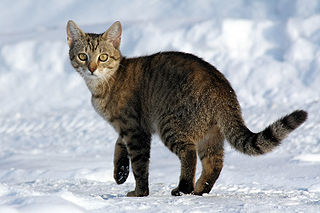

In [127]:
for image_features in parsed_image_dataset.take(1):
    print((image_features))
    image_string = image_features['image_raw'].numpy()
    print()
    print(repr(image_string))
    display.display(display.Image(data=image_string))


<tf.Tensor: id=60719, shape=(), dtype=string, numpy='\n\xa0\x8c\x01\n\xd9\x8b\x01\n\timage_raw\x12\xca\x8b\x01\n\xc6\x8b\x01\n\xc2\x8b\x01\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

<IPython.core.display.Image object>

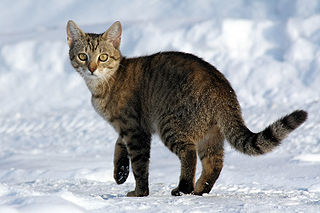

In [150]:
for raw_image in raw_image_dataset.take(1):
    print(repr(raw_image))
    print()
    print(tf.train.Example.FromString(raw_image.numpy()))
    temp2 = tf.train.Example.FromString(raw_image.numpy())
    image_string = temp2.features.feature['image_raw']
    display.display(display.Image(data=image_string))
    display.display(display.Image(data=image_string.bytes_list.value[0]))

In [155]:
label = temp2.features.feature['label']
print(label)
label.int64_list.value[0]

int64_list {
  value: 0
}



0L

In [149]:
image_string.bytes_list.value[0]

'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\'\x11\x00\x02\x02\x02\x02\x02\x02\x03\x01\x01\x00\x03\x00\x00\x00\x00\x00\x01\x02\x11!1\x03\x12AQ\x04a

In [140]:
image_string = temp2.features.feature['image_raw']

<IPython.core.display.Image object>

In [141]:
print((image_string))

bytes_list {
  value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\333\000C\000\006\004\005\006\005\004\006\006\005\006\007\007\006\010\n\020\n\n\t\t\n\024\016\017\014\020\027\024\030\030\027\024\026\026\032\035%\037\032\033#\034\026\026 , #&\')*)\031\037-0-(0%()(\377\333\000C\001\007\007\007\n\010\n\023\n\n\023(\032\026\032((((((((((((((((((((((((((((((((((((((((((((((((((\377\300\000\021\010\000\325\001@\003\001\021\000\002\021\001\003\021\001\377\304\000\034\000\000\002\002\003\001\001\000\000\000\000\000\000\000\000\000\000\003\004\002\005\001\006\007\010\000\377\304\000?\020\000\002\001\003\003\002\005\001\005\006\005\002\006\003\000\000\001\002\003\000\004\021\005\022!1A\006\023\"Qaq\007\0242\201\221\010#B\241\261\360\025R\301\321\361b\341\026$3Cr\2024S\262\377\304\000\032\001\000\003\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\001\002\003\004\005\006\377\304\000\'\021\000\002\002\002\002\002\002\003\001\001\000\003\000\000\000\000\000\001\0